In [1]:
!pip install tpot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 KB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 KB 5.0 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11954 sha256=a221de8d3b1e610ce7ae47bef17f5ef027cb14ca8f37139d5111e71ec79babc1
  Stored in directory: /root/.cache/pip/wheels/48/8c/93/3afb1916772591fe6bcc25cdf8b1c5bdc362f0ec8e2f0fd413
Successfully built stopit


# Selección de modelos

In [2]:
from sklearn import  tree
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time

# Carga de datos
Usamos de nuevo los datos para predecir la concesión de un préstamo

In [3]:
url_file = "https://raw.githubusercontent.com/zng489/Decision_trees_and_Random-Forest-madfhantr-/main/madfhantr.csv"
df_raw = pd.read_csv(url_file)
df_raw.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
def preprocessing_madfhantr(df):
  # eliminamos nans
  df = df.dropna()
  # creamos columna con nombres target 
  df["targetNames"] = df["Loan_Status"]
  # variables categóricas que tenemos que convertir
  cat_vars = ["Gender","Married","Dependents","Education","Self_Employed","Property_Area","Loan_Status"]
  for cat_var in cat_vars:
    df.loc[:,cat_var] = pd.Categorical(df[cat_var]).codes
  # renombramos la columna target
  df = df.rename(columns={"Loan_Status":"target"})
  df = df.set_index("Loan_ID")
  return df



In [6]:
df = preprocessing_madfhantr(df_raw)


<ipython-input-5-19622b6e91dc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["targetNames"] = df["Loan_Status"]
<ipython-input-5-19622b6e91dc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,cat_var] = pd.Categorical(df[cat_var]).codes


# Exploración de datos

In [7]:

df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,target,targetNames
Loan_ID,,,,,,,,,,,,,
LP001003,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0,N
LP001005,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1,Y
LP001006,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1,Y
LP001008,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1,Y
LP001011,1,1,2,0,1,5417,4196.0,267.0,360.0,1.0,2,1,Y


In [8]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 480 entries, LP001003 to LP002990
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             480 non-null    int8   
 1   Married            480 non-null    int8   
 2   Dependents         480 non-null    int8   
 3   Education          480 non-null    int8   
 4   Self_Employed      480 non-null    int8   
 5   ApplicantIncome    480 non-null    int64  
 6   CoapplicantIncome  480 non-null    float64
 7   LoanAmount         480 non-null    float64
 8   Loan_Amount_Term   480 non-null    float64
 9   Credit_History     480 non-null    float64
 10  Property_Area      480 non-null    int8   
 11  target             480 non-null    int8   
 12  targetNames        480 non-null    object 
dtypes: float64(4), int64(1), int8(7), object(1)
memory usage: 29.5+ KB


In [9]:
df.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,target
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.820833,0.647917,0.777083,0.202083,0.137500,5364.231250,1581.093583,144.735417,342.050000,0.854167,1.022917,0.691667
std,0.383892,0.478118,1.020815,0.401973,0.344734,5668.251251,2617.692267,80.508164,65.212401,0.353307,0.776411,0.462287
min,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,36.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,2898.750000,0.000000,100.000000,360.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,3859.000000,1084.500000,128.000000,360.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,2.000000,0.000000,0.000000,5852.500000,2253.250000,170.000000,360.000000,1.000000,2.000000,1.000000
max,1.000000,1.000000,3.000000,1.000000,1.000000,81000.000000,33837.000000,600.000000,480.000000,1.000000,2.000000,1.000000


# Modelización con GridSearch y Random Search con árboles de decisión
Creamos un árbol de regresión haciendo un train/test split del 30%.

In [10]:
targetCol = "target"
featuresCols = [col for col in df.columns if col not in ["target","targetNames"]]
X, y = df[featuresCols],df[targetCol]

In [11]:

featuresCols

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'Property_Area']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [13]:
print(X_train.shape)
print(X_test.shape)


(360, 11)
(120, 11)


### Grid Search

In [14]:
tree.DecisionTreeClassifier?

In [15]:
grid = { 
    'max_depth' : [3,5,7,9],
    'criterion' :['gini','entropy'],
    'random_state' : [18]
}
tree_cv = GridSearchCV(estimator=tree.DecisionTreeClassifier(), param_grid=grid, cv= 5)


In [16]:
%%time
tree_cv.fit(X_train, y_train)


CPU times: user 364 ms, sys: 3.38 ms, total: 368 ms
Wall time: 564 ms


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 9], 'random_state': [18]})

In [17]:
tree_cv.best_estimator_

DecisionTreeClassifier(max_depth=3, random_state=18)

In [18]:
#tree_cv.cv_results_

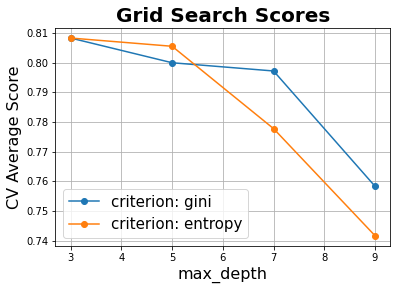

In [19]:
def plot_grid_search(cv_results, grid, name_param_1, name_param_2):
    grid_param_1 = grid[name_param_1]
    grid_param_2 = grid[name_param_2]
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method 
plot_grid_search(tree_cv.cv_results_, grid, "max_depth", "criterion")

In [20]:
y_pred = tree_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[15 28]
 [ 7 70]]
              precision    recall  f1-score   support

           0       0.68      0.35      0.46        43
           1       0.71      0.91      0.80        77

    accuracy                           0.71       120
   macro avg       0.70      0.63      0.63       120
weighted avg       0.70      0.71      0.68       120



### Random Search

In [21]:
grid = { 
    'max_depth' : [3,5,7],
    'criterion' :['gini','entropy'],
    'random_state' : [18]
}
tree_rs = RandomizedSearchCV(estimator=tree.DecisionTreeClassifier(), param_distributions =grid, cv= 5)


In [22]:
%%time
tree_rs.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: user 237 ms, sys: 6.41 ms, total: 244 ms
Wall time: 262 ms


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 7],
                                        'random_state': [18]})

In [23]:
tree_cv_best=tree_rs.best_estimator_
tree_cv_best

DecisionTreeClassifier(max_depth=3, random_state=18)

In [24]:
y_pred = tree_rs.predict(X_test) # o tree_cv_best
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[15 28]
 [ 7 70]]
              precision    recall  f1-score   support

           0       0.68      0.35      0.46        43
           1       0.71      0.91      0.80        77

    accuracy                           0.71       120
   macro avg       0.70      0.63      0.63       120
weighted avg       0.70      0.71      0.68       120



<Axes: >

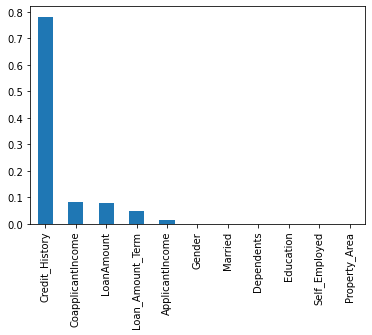

In [25]:
pd.Series(tree_cv_best.feature_importances_,featuresCols).sort_values(ascending=False).plot(kind="bar")

# Modelización con Random Forest y XGBoost
Ejercicio práctico
**Random Forest**
- Haz un modelo de Random Forest y usa Grid Search (con cv=5) para evaluar los mejores hiperparámetros. Evalúa los tiempos de cómputo con el comando %%time.
El grid está definido en la siguiente celda.
- Mira cual es el mejor estimador y evalúa los resultados con classification_report.
- Muestra la feature Importance.
- Haz el mismo proceso de evaluación de hiperparámetros con Grid Search, evaluando el tiempo de cómputo y mira si la solución obtenida es la misma a la del Grid Search.

**XGBoost**
- Realiza una cross validation con el XGboost
- Haz un hiperparámeter tunning con el grid siguiente para XGboost 

In [26]:
from sklearn import  ensemble

In [27]:
grid = { 
    'n_estimators': [200,300,500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [3,5,7,9],
    'criterion' :['gini'],
    'random_state' : [18]
}


In [28]:
%%time
# haz el gridsearchCV con cv=5

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs


Evaluamos las métricas

In [29]:
# evalúa las métricas


In [30]:
# muestra el mejor estimador
rf_cv_best=None # completar

print(rf_cv_best)

None


In [31]:
# muestra la feature importance

In [32]:
%%time
## haz el randomized search con cv=5

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


**Cross Validation e hiperparámeter tuning usando XGboost**




In [33]:
import xgboost as xgb

In [34]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [35]:
# parámetros para el cross validation
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

In [36]:
# haz la cross validation con los siguientes parámetros
# nfold=3, num_boost_round=50, early_stopping_rounds=10,  as_pandas=True,seed=42


In [37]:
## grid para hacer el randomizedSearchCV xgboost hyperparámetros
## ojo! aquí como estimador hay que usar XGBClassifier
param_grid = {
    'max_depth': [3,5,7],  # the maximum depth of each tree
    'eta': [0.1,0.3],  # the training step for each iteration
    'objective': ['binary:logistic'],  # error evaluation for multiclass training
    }  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

## metodos bayesianos



In [38]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

space= {
    'max_depth': hp.choice('max_depth', np.arange(1, 14, dtype=int)), #hp.quniform("max_depth", 3, 18, 1),
    'eta': 0.3,  # the training step for each iteration
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2} 

def objective(space):
    clf=xgb.XGBClassifier(
                    **space)
    
    
    clf.fit(X_train, y_train, 
            verbose=False)
    

    pred = clf.predict(X_test)
    best_preds = np.asarray([np.argmax(line) for line in pred])

    score = roc_auc_score(y_test, best_preds)
    #print ("SCORE:", accuracy)
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK }
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
#best_hyperparams = {key:int(val) if val.is_integer() else val for key, val in best_hyperparams.items()}

100%|██████████| 100/100 [00:37<00:00,  2.65trial/s, best loss: 0.33373603141045005]


In [39]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'max_depth': 5}


In [40]:
best_hyperparams.update({'eta': 0.3,  # the training step for each iteration
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2})


In [41]:
from xgboost.sklearn import XGBClassifier
bst = xgb.train(best_hyperparams, dtrain, num_round)
y_pred = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in y_pred])
score = roc_auc_score(y_test, best_preds)
print(confusion_matrix(y_test, best_preds))
print(classification_report(y_test, best_preds))
print(score)

[[19 24]
 [13 64]]
              precision    recall  f1-score   support

           0       0.59      0.44      0.51        43
           1       0.73      0.83      0.78        77

    accuracy                           0.69       120
   macro avg       0.66      0.64      0.64       120
weighted avg       0.68      0.69      0.68       120

0.6365146481425552


### Algoritmos genéticos


In [42]:

from tpot import TPOTClassifier

# Create the tpot classifier
tpot_clf = TPOTClassifier(generations=3, population_size=4,
                          offspring_size=3, scoring="accuracy",
                          verbosity=2, random_state=73, cv=2)

# Fit the classifier to the training data
tpot_clf.fit(X_train, y_train)

# Score on the test set
print(tpot_clf.score(X_test, y_test))

Optimization Progress:   0%|          | 0/13 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8305555555555555

Generation 2 - Current best internal CV score: 0.8305555555555555

Generation 3 - Current best internal CV score: 0.8305555555555555

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.8500000000000001, min_samples_leaf=9, min_samples_split=5, n_estimators=100)
0.75


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py:794: FutureWarning: sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.
  warnings.warn(
